## Import Required Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif

## Import Training Data

In [3]:
data = pd.read_csv('Train.csv')
data

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0,0.512114,0.592237,0.559612,0.613175,0.613175,0.999062,0.797565,0.809463,0.303636,...,0.826537,0.011653,0.623926,0.613173,0.842158,0.278042,0.026838,0.565373,1,0.039038
1,0,0.492224,0.562582,0.551100,0.600311,0.600333,0.998979,0.797417,0.809353,0.303551,...,0.811231,0.007018,0.623684,0.600313,0.841243,0.279404,0.026974,0.565902,1,0.030731
2,0,0.527812,0.585805,0.576958,0.605457,0.605363,0.999076,0.797615,0.809512,0.303694,...,0.823664,0.003584,0.628218,0.605454,0.841501,0.275661,0.026856,0.565451,1,0.109045
3,0,0.565690,0.639610,0.624819,0.602769,0.602769,0.999053,0.797495,0.809416,0.303535,...,0.842413,0.005825,0.624091,0.602766,0.843951,0.280197,0.026814,0.565266,1,0.027782
4,0,0.516112,0.586077,0.568392,0.605543,0.605551,0.999075,0.797713,0.809605,0.303867,...,0.817378,0.005758,0.624746,0.605544,0.841366,0.276985,0.026867,0.565496,1,0.052249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
5451,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
5452,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
5453,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


## Exploratory Data Analysis

### Check Null Values and duplicates

In [4]:
print ("Cells with Null Values : ", data.isnull().sum().sum())
print ("Duplicated rows :" , data.duplicated().sum())

Cells with Null Values :  0
Duplicated rows : 0


### Count of Non-Bankrupt and Bankrupt Data

Number of Bankrupted companies:  154
Number of Non-Bankrupted companies:  5301


<Axes: xlabel='Bankrupt?', ylabel='count'>

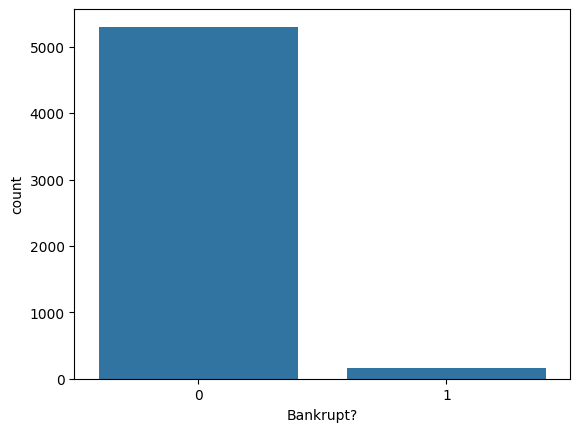

In [5]:
print ("Number of Bankrupted companies: ", len(data[data['Bankrupt?'] == 1]))
print ("Number of Non-Bankrupted companies: ", len(data[data['Bankrupt?'] == 0]))
sns.countplot( x = data['Bankrupt?'], data=data)

#### This is a highly imbalanced dataset, because the bankrupt class makes up only about 2.8% of the data. So Oversampling is to be done to prevent model being biased to Non-bankrupt Class

### Analysing the Data Columns

In [6]:
data.shape

(5455, 96)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5455 entries, 0 to 5454
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 5455 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  5455 non-null   float64
 2    ROA(A) before interest and % after tax                   5455 non-null   float64
 3    ROA(B) before interest and depreciation after tax        5455 non-null   float64
 4    Operating Gross Margin                                   5455 non-null   float64
 5    Realized Sales Gross Margin                              5455 non-null   float64
 6    Operating Profit Rate                                    5455 non-null   float64
 7    Pre-tax net Interest Rate                                5455 non-null   float64
 8    After-tax net Int

### Analysing the feautures with integer values

In [8]:
data.dtypes[data.dtypes == 'int64'].index

Index(['Bankrupt?', ' Liability-Assets Flag', ' Net Income Flag'], dtype='object')

In [9]:
print(data[[' Liability-Assets Flag','Bankrupt?']].value_counts())

 Liability-Assets Flag  Bankrupt?
0                       0            5299
                        1             149
1                       1               5
                        0               2
Name: count, dtype: int64


In [10]:
print(data[[' Net Income Flag','Bankrupt?']].value_counts())

 Net Income Flag  Bankrupt?
1                 0            5301
                  1             154
Name: count, dtype: int64


### Net Income flag is 1 for every data, so it is of no use for our model development. So we can remove it.

In [11]:
data = data.drop(columns = " Net Income Flag")
data.shape

(5455, 95)

### Analysing the features with Numeric Values

In [12]:
data.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
count,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,...,5455.000000,5455.000000,5.455000e+03,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000,5455.000000
mean,0.028231,0.507698,0.560788,0.555957,0.608880,0.608862,0.998693,0.797137,0.809032,0.303661,...,0.001283,0.808851,2.328763e+07,0.623872,0.608878,0.840506,0.280262,0.027138,0.565342,0.050020
std,0.165647,0.063940,0.069656,0.065135,0.018345,0.018328,0.014545,0.014384,0.015192,0.012473,...,0.035802,0.042398,4.207705e+08,0.012348,0.018345,0.011277,0.014669,0.006548,0.009226,0.053405
min,0.000000,0.024277,0.000000,0.033514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.344652,0.000000,0.000000,0.172065,0.000000
25%,0.000000,0.477210,0.536034,0.527437,0.600837,0.600812,0.998970,0.797388,0.809313,0.303468,...,0.000000,0.797123,8.080725e-04,0.623687,0.600832,0.840142,0.276771,0.026791,0.565158,0.024845
50%,0.000000,0.505484,0.562255,0.555222,0.607021,0.606999,0.999027,0.797471,0.809382,0.303526,...,0.000000,0.812325,1.893891e-03,0.623904,0.607019,0.841302,0.278567,0.026803,0.565220,0.035048
75%,0.000000,0.541242,0.593954,0.589914,0.615301,0.615287,0.999109,0.797598,0.809486,0.303588,...,0.000000,0.829114,4.845815e-03,0.624185,0.615300,0.842516,0.281291,0.026883,0.565594,0.056410
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,9.820000e+09,0.956387,1.000000,0.996912,1.000000,0.464388,0.736985,1.000000


In [13]:
print(data.mean().apply(lambda x: f"{x:.6f}").to_string())

Bankrupt?                                                            0.028231
 ROA(C) before interest and depreciation before interest             0.507698
 ROA(A) before interest and % after tax                              0.560788
 ROA(B) before interest and depreciation after tax                   0.555957
 Operating Gross Margin                                              0.608880
 Realized Sales Gross Margin                                         0.608862
 Operating Profit Rate                                               0.998693
 Pre-tax net Interest Rate                                           0.797137
 After-tax net Interest Rate                                         0.809032
 Non-industry income and expenditure/revenue                         0.303661
 Continuous interest rate (after tax)                                0.781335
 Operating Expense Rate                                     1888837434.647613
 Research and development expense rate                      2022

#### We observe that there are some features with high mean values

### Analysing high mean features

In [14]:
pd.options.display.float_format = '{:.6f}'.format
print(data[["Bankrupt?", " Interest-bearing debt interest rate"]].to_string())

      Bankrupt?   Interest-bearing debt interest rate
0             0                              0.000593
1             0                              0.000619
2             0                              0.000829
3             0                              0.000761
4             0                              0.000412
5             0                              0.001309
6             0                              0.000568
7             0                              0.000449
8             0                              0.000669
9             0                              0.000000
10            0                              0.000667
11            0                              0.001020
12            0                              0.000510
13            0                              0.000363
14            0                              0.000846
15            0                              0.000948
16            0                              0.000655
17            0             

### We can see that values are wrong in some columns . Our actual value should be between 0 and 1 but some values are so large than that ..

### Removing Data Errors

In [15]:
columns = [col for col in data.columns if (data[col] > 1).any()]

for col in columns:
    print(f"{col}: {len(data[data[col] > 1])}")

 Operating Expense Rate: 1724
 Research and development expense rate: 3106
 Interest-bearing debt interest rate: 208
 Revenue Per Share (Yuan ¥): 5
 Total Asset Growth Rate: 4690
 Net Value Growth Rate: 2
 Current Ratio: 1
 Quick Ratio: 9
 Total debt/Total net worth: 7
 Accounts Receivable Turnover: 21
 Average Collection Days: 18
 Inventory Turnover Rate (times): 2221
 Fixed Assets Turnover Frequency: 915
 Revenue per person: 1
 Allocation rate per person: 9
 Quick Assets/Current Liability: 3
 Cash/Current Liability: 34
 Inventory/Current Liability: 99
 Long-term Liability to Current Assets: 88
 Current Asset Turnover Rate: 869
 Quick Asset Turnover Rate: 1593
 Cash Turnover Rate: 3105
 Fixed Assets to Assets: 1
 Total assets to GNP price: 20


#### So we remove the columns with large data errors and replace smaller errors with the median of the column.

### Removing columns with large Errors

In [17]:
large_err = [col for col in data.columns if (data[col] > 1).sum() > 200]
print(large_err)

data.drop(columns = large_err, inplace = True)

[' Operating Expense Rate', ' Research and development expense rate', ' Interest-bearing debt interest rate', ' Total Asset Growth Rate', ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency', ' Current Asset Turnover Rate', ' Quick Asset Turnover Rate', ' Cash Turnover Rate']


### Replacing smaller errors with medians

In [19]:
minor_err = [col for col in data.columns if 0 < (data[col] > 1).sum() <= 200]
print(minor_err)

for col in minor_err:
    data[col] = data[col].where(data[col] <= 1, np.nan)

data.fillna({col: data[col].median(skipna=True) for col in minor_err}, inplace=True)

[' Revenue Per Share (Yuan ¥)', ' Net Value Growth Rate', ' Current Ratio', ' Quick Ratio', ' Total debt/Total net worth', ' Accounts Receivable Turnover', ' Average Collection Days', ' Revenue per person', ' Allocation rate per person', ' Quick Assets/Current Liability', ' Cash/Current Liability', ' Inventory/Current Liability', ' Long-term Liability to Current Assets', ' Fixed Assets to Assets', ' Total assets to GNP price']


In [20]:
data.shape

(5455, 86)

In [21]:
print(data.mean().apply(lambda x: f"{x:.6f}").to_string())

Bankrupt?                                                   0.028231
 ROA(C) before interest and depreciation before interest    0.507698
 ROA(A) before interest and % after tax                     0.560788
 ROA(B) before interest and depreciation after tax          0.555957
 Operating Gross Margin                                     0.608880
 Realized Sales Gross Margin                                0.608862
 Operating Profit Rate                                      0.998693
 Pre-tax net Interest Rate                                  0.797137
 After-tax net Interest Rate                                0.809032
 Non-industry income and expenditure/revenue                0.303661
 Continuous interest rate (after tax)                       0.781335
 Cash flow rate                                             0.467710
 Tax rate (A)                                               0.111612
 Net Value Per Share (B)                                    0.192240
 Net Value Per Share (A)          

### Now we cleaned our dataset and our next task is to prepare it for model training because using 86 features to train a model results in high noise and poor model performance while testing, so we try extracting the most important features which significantly affects the result and use this subset of columns to train our model

### Observing the correlation among features

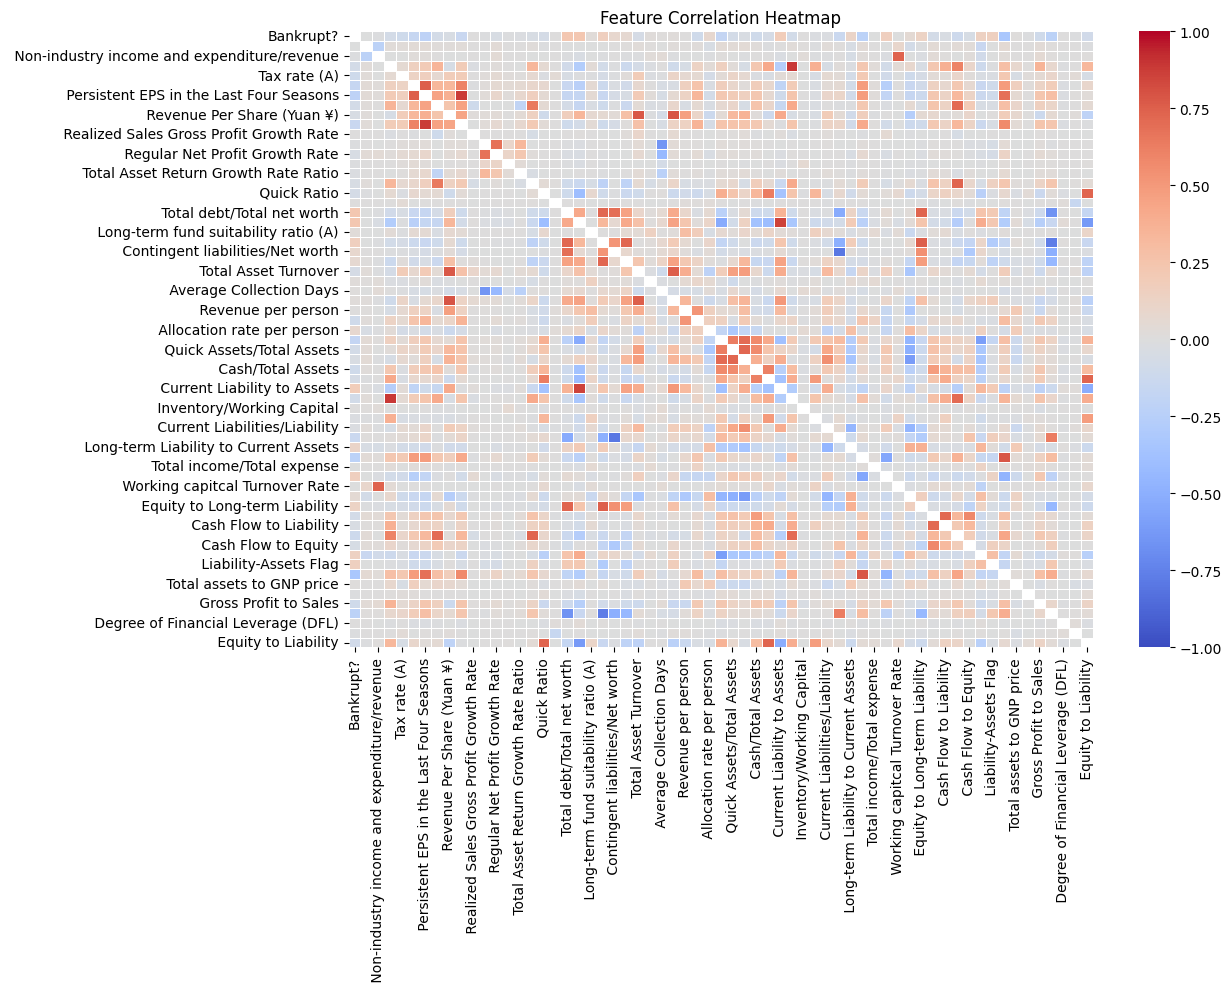

In [32]:
corr_matrix = data.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, mask=np.eye(len(corr_matrix),dtype=bool), cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

### We can observe that some columns are highly correlated with each other . So considering only one of the highly correlated columns is sufficient to train the model .

### Dropping one of the highly Correlated features

In [28]:
def drop_high_corr_features(data, threshold=0.90, target='Bankrupt?'):
    features = [col for col in data.columns if col != target]

    corr_matrix = data[features].corr().abs()

    target_corr = data[features].corrwith(data[target]).abs()

    dropped = []

    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            f1 = features[i]
            f2 = features[j]

            if f1 in dropped or f2 in dropped:
                continue

            if corr_matrix.loc[f1, f2] > threshold:
                if target_corr[f1] >= target_corr[f2]:
                    dropped.append(f2)
                else:
                    dropped.append(f1)

    new_data = data.drop(columns=dropped)
    return new_data, dropped

data, dropped = drop_high_corr_features(data, threshold=0.90, target='Bankrupt?')

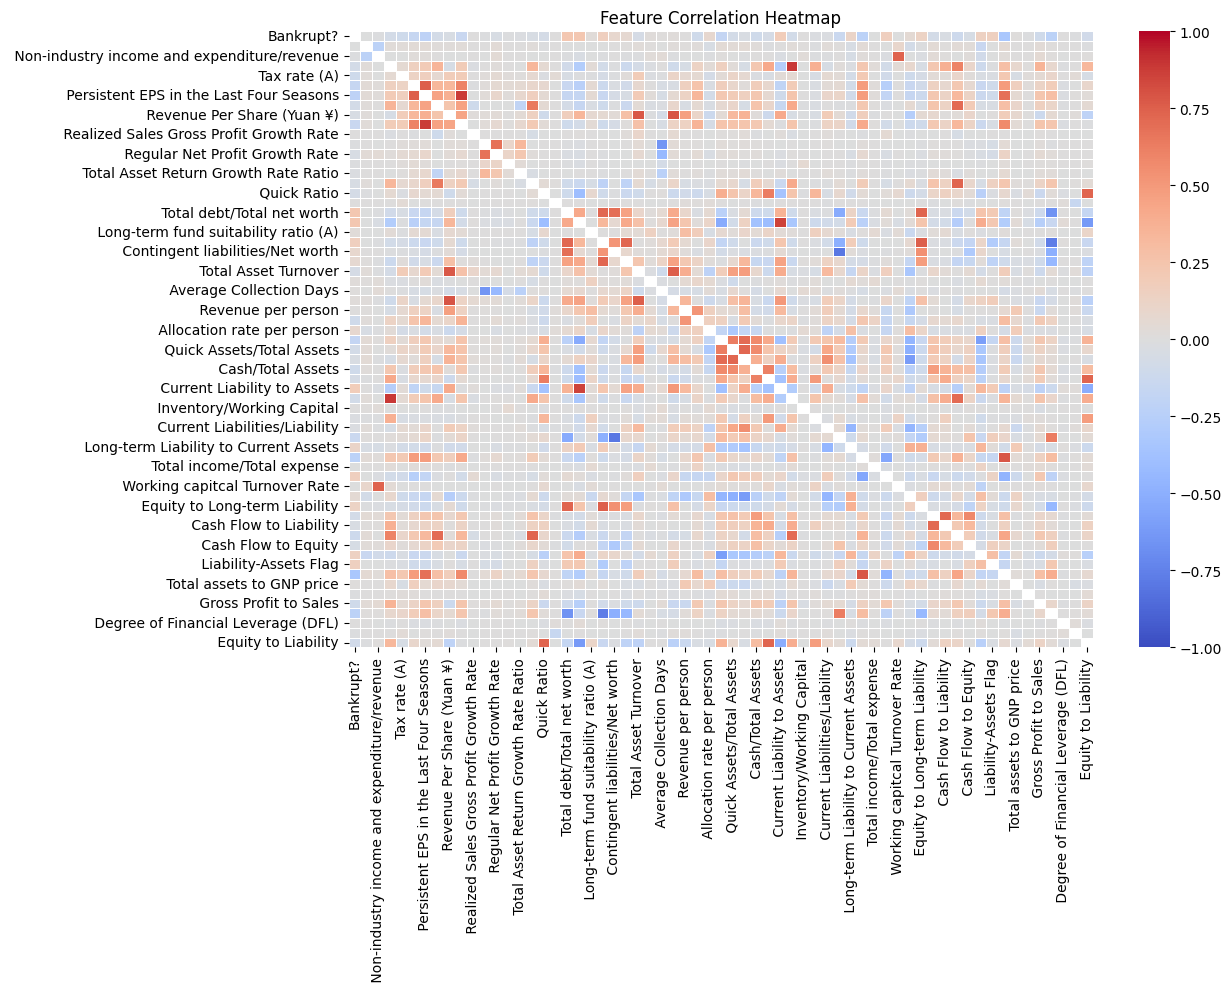

In [31]:
corr_matrix = data.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, mask=np.eye(len(corr_matrix),dtype=bool), cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [30]:
data.shape

(5455, 63)

#### Still we have 63 features which is too much ... So during model training we use feature selection methods to select the best subset for model training

# Model Training

## Using ANOVA for feature selection

In [71]:
def select_features_anova(X_data, y_data, top_n=30):

    selector = SelectKBest(score_func=f_classif, k=top_n)
    selector.fit(X_data, y_data)
    mask = selector.get_support()
    selected_features = X_data.columns[mask].tolist()
    return selected_features

In [72]:
X = data.drop(columns=['Bankrupt?'])
y = data['Bankrupt?']

selected_features = select_features_anova(X, y, top_n=30)
X_selected = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

## Using SMOTE for Oversampling

In [73]:
sm = SMOTE(random_state=42,sampling_strategy=0.9)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

## Gaussian Modelling

In [74]:
gnb_model = GaussianNB()
gnb_model.fit(X_train_scaled, y_train_sm)

GaussianNB()

## Creating DNN Model

In [75]:
def dnn_model(input_dim):

    inputs = Input(shape=(input_dim,))
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.0004),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

In [76]:
majority_count = np.sum(y_train_sm == 0)
minority_count = np.sum(y_train_sm == 1)
weight_minority = majority_count / minority_count
class_weights = {0: 1, 1: weight_minority}
print("Class Weights:", class_weights)

Class Weights: {0: 1, 1: np.float64(1.1113731656184487)}


In [77]:
dnn = dnn_model(input_dim=X_train_scaled.shape[1])
dnn.fit(X_train_scaled, y_train_sm,
              epochs=300,
              batch_size=64,
              validation_split=0.2,
              class_weight=class_weights,
              verbose=0)

## Prediction using Ensemble methods

In [78]:
gnb_prob = gnb_model.predict_proba(X_test_scaled)[:, 1]
dnn_prob = dnn.predict(X_test_scaled).flatten()

prob = (gnb_prob + dnn_prob) / 2

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


## Finding the best threshold

In [82]:
thresholds = np.arange(0.30, 0.80, 0.01)
best_f1 = 0
best_thresh = 0.5
for thresh in thresholds:
    y_pred_temp = (prob > thresh).astype("int32")
    current_f1 = f1_score(y_test, y_pred_temp)
    print(f"Threshold: {thresh:.2f}, F1-Score: {current_f1:.4f}")
    if current_f1 > best_f1:
        best_f1 = current_f1
        best_thresh = thresh

print(f"\nBest threshold: {best_thresh:.2f} with F1-Score: {best_f1:.4f}")

y_pred_final = (prob > best_thresh).astype("int32")

Threshold: 0.30, F1-Score: 0.4310
Threshold: 0.31, F1-Score: 0.4310
Threshold: 0.32, F1-Score: 0.4348
Threshold: 0.33, F1-Score: 0.4505
Threshold: 0.34, F1-Score: 0.4505
Threshold: 0.35, F1-Score: 0.4545
Threshold: 0.36, F1-Score: 0.4587
Threshold: 0.37, F1-Score: 0.4630
Threshold: 0.38, F1-Score: 0.4717
Threshold: 0.39, F1-Score: 0.4717
Threshold: 0.40, F1-Score: 0.4762
Threshold: 0.41, F1-Score: 0.4762
Threshold: 0.42, F1-Score: 0.4854
Threshold: 0.43, F1-Score: 0.4902
Threshold: 0.44, F1-Score: 0.4752
Threshold: 0.45, F1-Score: 0.4752
Threshold: 0.46, F1-Score: 0.4752
Threshold: 0.47, F1-Score: 0.4646
Threshold: 0.48, F1-Score: 0.4742
Threshold: 0.49, F1-Score: 0.4792
Threshold: 0.50, F1-Score: 0.5185
Threshold: 0.51, F1-Score: 0.4444
Threshold: 0.52, F1-Score: 0.4194
Threshold: 0.53, F1-Score: 0.4333
Threshold: 0.54, F1-Score: 0.4333
Threshold: 0.55, F1-Score: 0.4068
Threshold: 0.56, F1-Score: 0.3860
Threshold: 0.57, F1-Score: 0.3860
Threshold: 0.58, F1-Score: 0.3860
Threshold: 0.5

## Model Evaluation

In [80]:
cm = confusion_matrix(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)
roc_auc = roc_auc_score(y_test, prob)
report = classification_report(y_test, y_pred_final)

print("\nFinal Ensemble Evaluation (GaussianNB + DNN):")
print("Confusion Matrix:")
print(cm)
print("\nPrecision:", np.round(precision, 4))
print("Recall:", np.round(recall, 4))
print("F1-Score:", np.round(f1_final, 4))
print("ROC-AUC:", np.round(roc_auc, 4))
print("\nClassification Report:")
print(report)


Final Ensemble Evaluation (GaussianNB + DNN):
Confusion Matrix:
[[1031   29]
 [  10   21]]

Precision: 0.42
Recall: 0.6774
F1-Score: 0.5185
ROC-AUC: 0.9297

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1060
           1       0.42      0.68      0.52        31

    accuracy                           0.96      1091
   macro avg       0.71      0.83      0.75      1091
weighted avg       0.97      0.96      0.97      1091

